## MT3DMS Supplemental Guide Problem 8.2

This example is for a recirculating well.  It is based on example problem 8.2
described in Zheng 2010. The problem consists of a two-dimensional, one-layer
model with flow from left to right. A solute is introduced into the flow field
by an injection well. Downgradient, an extraction well pumps at the same rate
as the injection well. This extracted water is then injected into two other
injection wells. This example is simulated with a GWT model, which receives
flow information from a separate GWF model. Results from the GWT Model are
compared with the results from an MT3DMS simulation that uses flows from a
separate MODFLOW-2005 simulation.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-mt3dsupp82"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 31  # Number of rows
ncol = 46  # Number of columns
delr = 10.0  # Column width ($m$)
delc = 10.0  # Row width ($m$)
top = 10.0  # Top of the model ($m$)
botm = 0.0  # Layer bottom elevation ($m$)
hydraulic_conductivity = 10.0  # Hydraulic conductivity ($md^{-1}$)
alpha_l = 10.0  # Longitudinal dispersivity ($m$)
alpha_th = 3.0  # Transverse horizontal dispersivity ($m$)
alpha_tv = 0.3  # Transverse vertical dispersivity ($m$)
total_time = 365.0  # Simulation time ($d$)
porosity = 0.3  # Porosity of mobile domain (unitless)

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((total_time, 1, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, inner_dvclose=1.00e-4)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=0.0)
    cinflow = 0.0
    chdlist1 = [[(0, i, 0), 1000.0 + 7.29e-4, cinflow] for i in range(nrow)]
    chdlist1 += [[(0, i, ncol - 1), 1000.0 + -4.5, 0.0] for i in range(nrow)]
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chdlist1,
        print_input=True,
        print_flows=True,
        save_flows=False,
        pname="CHD-1",
        auxiliary=[("CONCENTRATION")],
    )
    wellbottom = 0.0
    wellradius = 0.01
    ngwfnodes = 1
    concwell = 1000.0
    strt = 0.0
    mawpackagedata = [
        [iwell, wellradius, wellbottom, strt, "THIEM", ngwfnodes, concwell]
        for iwell in range(4)
    ]
    mawconnectiondata = [
        [0, 0, (0, 15, 15), 10.0, 0.0, 10.0, 0.1],
        [1, 0, (0, 15, 20), 10.0, 0.0, 10.0, 0.1],
        [2, 0, (0, 4, 15), 10.0, 0.0, 10.0, 0.1],
        [3, 0, (0, 26, 15), 10.0, 0.0, 10.0, 0.1],
    ]
    mawspd = [[0, "rate", 1.0], [1, "rate", -1.0]]

    flopy.mf6.ModflowGwfmaw(
        gwf,
        print_input=True,
        print_head=True,
        print_flows=True,
        save_flows=True,
        mover=True,
        no_well_storage=True,
        head_filerecord=f"{name}.maw.hds",
        budget_filerecord=f"{name}.maw.bud",
        packagedata=mawpackagedata,
        connectiondata=mawconnectiondata,
        perioddata=mawspd,
        pname="MAW-1",
        auxiliary=["CONCENTRATION"],
    )

    packages = [("maw-1",)]
    perioddata = [
        ("MAW-1", 1, "MAW-1", 2, "factor", 0.5),
        ("MAW-1", 1, "MAW-1", 3, "factor", 0.5),
    ]
    flopy.mf6.ModflowGwfmvr(
        gwf,
        maxmvr=len(perioddata),
        budget_filerecord=f"{name}.mvr.bud",
        maxpackages=len(packages),
        print_flows=True,
        packages=packages,
        perioddata=perioddata,
    )

    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def build_mf6gwt(sim_folder):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((total_time, 20, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtadv(gwt, scheme="upstream")
    flopy.mf6.ModflowGwtdsp(gwt, alh=alpha_l, ath1=alpha_th, atv=alpha_tv)
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
        ("GWFMOVER", "../mf6gwf/flow.mvr.bud", None),
        ("MAW-1", "../mf6gwf/flow.maw.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)

    mwtpackagedata = [
        (0, 0.0, 99.0, 999.0, "inject"),
        (1, 0.0, 99.0, 999.0, "extract"),
        (2, 0.0, 99.0, 999.0, "reinject1"),
        (3, 0.0, 99.0, 999.0, "reinject2"),
    ]
    mwtperioddata = [
        (0, "RATE", 1000.0),
        (0, "CONCENTRATION", 1000.0),
        (0, "STATUS", "ACTIVE"),
        (1, "STATUS", "ACTIVE"),
        (2, "STATUS", "ACTIVE"),
        (3, "STATUS", "ACTIVE"),
    ]
    flopy.mf6.modflow.ModflowGwtmwt(
        gwt,
        boundnames=True,
        save_flows=True,
        print_input=True,
        print_flows=True,
        print_concentration=True,
        concentration_filerecord=name + ".mwt.bin",
        budget_filerecord=name + ".mwt.bud",
        packagedata=mwtpackagedata,
        mwtperioddata=mwtperioddata,
        observations=None,
        pname="MAW-1",
        auxiliary=["aux1", "aux2"],
    )

    flopy.mf6.modflow.ModflowGwtmvt(gwt, print_flows=True)
    sourcerecarray = [
        ("CHD-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.cbc",
        concentration_filerecord=f"{name}.ucn",
        concentrationprintrecord=[
            ("COLUMNS", ncol, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[
            ("CONCENTRATION", "ALL"),
        ],
        printrecord=[
            ("CONCENTRATION", "ALL"),
            ("BUDGET", "ALL"),
        ],
    )
    return sim


def build_mf2005(sim_folder):
    print(f"Building mf2005 model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf2005")
    mf = flopy.modflow.Modflow(modelname=name, model_ws=sim_ws, exe_name="mf2005")
    perlen = [total_time]
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        nper=nper,
        perlen=perlen,
    )
    bas = flopy.modflow.ModflowBas(mf)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hydraulic_conductivity)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)

    h = 1000.0 + 7.29e-4
    chdspd = [[0, i, 0, h, h] for i in range(nrow)]
    h = 1000.0 + -4.5
    chdspd += [[0, i, ncol - 1, h, h] for i in range(nrow)]
    chd = flopy.modflow.ModflowChd(mf, stress_period_data=chdspd)

    q = 1.0
    welspd = [
        [0, 15, 15, q],  # injection
        [0, 15, 20, -q],  # extraction
        [0, 4, 15, 0.5 * q],  # reinjection
        [0, 26, 15, 0.5 * q],  # reinjection
    ]
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    return mf


def build_mt3dms(sim_folder, modflowmodel):
    print(f"Building mt3dms model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mt3d")
    mt = flopy.mt3d.Mt3dms(
        modelname=name,
        model_ws=sim_ws,
        exe_name="mt3dms",
        modflowmodel=modflowmodel,
        ftlfilename="../mf2005/mt3d_link.ftl",
    )
    dt0 = total_time / 20.0
    btn = flopy.mt3d.Mt3dBtn(mt, laycon=0, prsity=porosity, dt0=dt0, ifmtcn=1)
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0)
    dsp = flopy.mt3d.Mt3dDsp(
        mt, al=alpha_l, trpt=alpha_th / alpha_l, trpv=alpha_tv / alpha_l
    )

    ssmspd = [
        [0, 15, 15, 1000.0, 2],
        [0, 4, 15, -711, 2],
        [0, 26, 15, -711, 2],
    ]
    ssm = flopy.mt3d.Mt3dSsm(mt, mxss=66, stress_period_data=ssmspd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    return mt


def build_models(sim_name):
    sim_mf6gwf = build_mf6gwf(sim_name)
    sim_mf6gwt = build_mf6gwt(sim_name)
    sim_mf2005 = build_mf2005(sim_name)
    sim_mt3dms = build_mt3dms(sim_name, sim_mf2005)
    return sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms


def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)
    sim_mf2005.write_input()
    sim_mt3dms.write_input()


@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    success, buff = sim_mf6gwf.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf6gwt.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf2005.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mt3dms.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5, 3)


def plot_results(sims, idx):
    print("Plotting model results...")
    sim_mf6gwf, sim_mf6gwt, _, sim_mt3dms = sims
    gwf = sim_mf6gwf.flow
    gwt = sim_mf6gwt.trans

    with styles.USGSMap() as fs:
        conc = gwt.output.concentration().get_data()

        sim_ws = sim_mt3dms.model_ws
        fname = os.path.join(sim_ws, "MT3D001.UCN")
        cobjmt = flopy.utils.UcnFile(fname)
        concmt = cobjmt.get_data()

        fig, ax = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
        pmv.plot_bc(ftype="MAW", color="red")
        pmv.plot_bc(ftype="CHD")
        pmv.plot_grid(linewidths=0.25)

        a = np.ma.masked_less(conc, 0.01)
        pa = pmv.plot_array(a, cmap="jet", alpha=0.25)
        plt.colorbar(pa, shrink=0.5)

        levels = [0.01, 0.1, 1, 10, 100]
        cs1 = pmv.contour_array(concmt, levels=levels, colors="r")

        cs2 = pmv.contour_array(conc, levels=levels, colors="b", linestyles="--")
        ax.clabel(cs2, cs2.levels[::1], fmt="%3.2f", colors="b")

        labels = ["MT3DMS", "MODFLOW 6"]
        lines = [cs1.collections[0], cs2.collections[0]]
        ax.legend(lines, labels, loc="lower right")

        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-map.png"
            fpth = figs_path / fname
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-mt3dsupp82
Building mf6gwt model...ex-gwt-mt3dsupp82
Building mf2005 model...ex-gwt-mt3dsupp82


Building mt3dms model...ex-gwt-mt3dsupp82


run_models took 212.57 ms
Plotting model results...


/tmp/ipykernel_14099/530823780.py:36: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  lines = [cs1.collections[0], cs2.collections[0]]
/tmp/ipykernel_14099/530823780.py:36: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  lines = [cs1.collections[0], cs2.collections[0]]


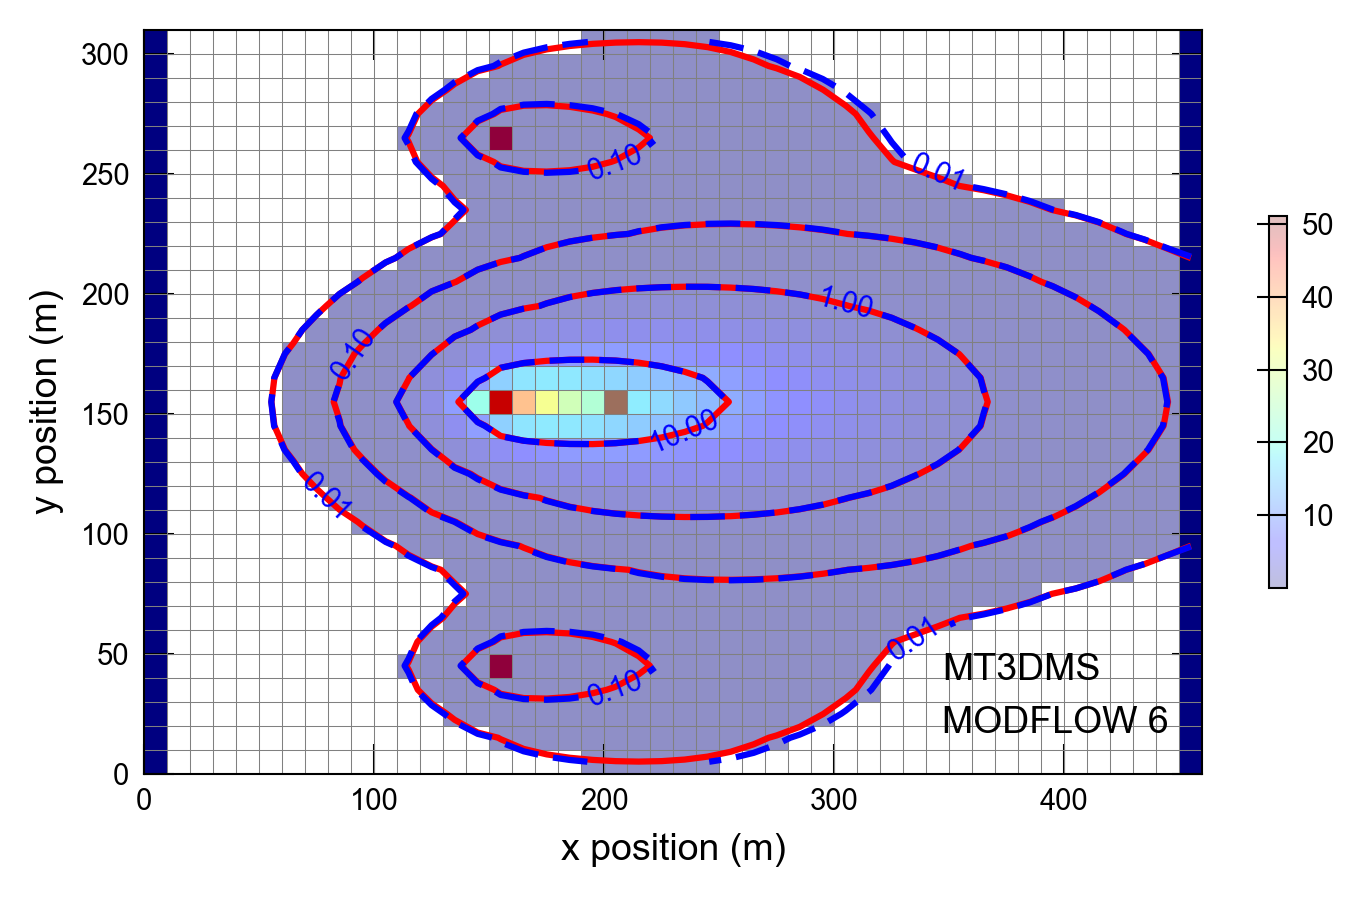

In [5]:
def scenario(idx, silent=True):
    sim = build_models(example_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)


scenario(0)